In [1]:
%cd ..

/home/eli/AnacondaProjects/surprisal_regression


In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pyro
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
from src.models.components.linear_regression import TrialwiseLinearRegression

In [4]:
SYNTHETIC_REGRESSORS = torch.tensor([[
    [1, 0, 0, 0, -math.log2(0.95), 0, -math.log2(0.95)], # 45-degree orientation, no repetitions, null surprisal
    [1, 0, 1, 0, -math.log2(0.95), 0, -math.log2(0.95) * 2], # 45-degree orientation, 1 repetition, null surprisal
    [1, 0, 2, 0, -math.log2(0.95), 0, -math.log2(0.95) * 3], # 45-degree orientation, 2 repetitions, null surprisal
    [0, 1, 0, -math.log2(0.8), -math.log2(0.05), -math.log2(0.8), -math.log2(0.05)], # 135-degree orientation, no repetitions, mild surprisal
], [
    [1, 0, 0, 0, -math.log2(0.95), 0, -math.log2(0.95)], # 45-degree orientation, no repetitions, null surprisal
    [1, 0, 1, 0, -math.log2(0.95), 0, -math.log2(0.95) * 2], # 45-degree orientation, 1 repetition, null surprisal
    [1, 0, 2, 0, -math.log2(0.95), 0, -math.log2(0.95) * 3], # 45-degree orientation, 2 repetitions, null surprisal
    [1, 0, 3, -math.log2(0.2), -math.log2(0.95), -math.log2(0.2), -math.log2(0.95) * 4], # 135-degree orientation, 3 repetitions, greater surprisal
], [
    [1, 0, 0, -math.log2(0.5), -math.log2(0.5), 1., 1.], # 45-degree orientation, no repetitions, uniform surprisal
    [1, 0, 1, -math.log2(0.5), -math.log2(0.5), 2., 2.], # 45-degree orientation, 1 repetition, uniform surprisal
    [0, 1, 0, -math.log2(0.5), -math.log2(0.5), 3., 3.], # 135-degree orientation, no repetitions, uniform surprisal
    [1, 0, 0, -math.log2(0.5), -math.log2(0.5), 4., 4.] # 45-degree orientation, no repetitions, uniform surprisal
], [
    [1, 0, 0, -math.log2(1.), -math.log2(0.5), -math.log2(1.), 1.], # 45-degree orientation, no repetitions, random surprisal
    [1, 0, 1, -math.log2(1.), -math.log2(0.5), -math.log2(1.), 2.], # 45-degree orientation, 1 repetition, null surprisal
    [1, 0, 2, -math.log2(1.), -math.log2(0.5), -math.log2(1.), 3.], # 45-degree orientation, 1 repetition, null surprisal
    [1, 0, 3, -math.log2(1.), -math.log2(0.5), -math.log2(1.), 4.], # 45-degree orientation, 1 repetition, null surprisal
]])

In [5]:
SYNTHETIC_REGRESSORS.shape

torch.Size([4, 4, 7])

In [6]:
generative = TrialwiseLinearRegression(num_regressors=13, num_stimuli=4)

In [7]:
generative.baseline_p_loc = nn.Parameter(torch.ones(1) * 2)
generative.baseline_p_log_scale = nn.Parameter(torch.zeros(1))

generative.repetition_p_concentration = nn.Parameter(torch.ones(1))
generative.repetition_p_rate = nn.Parameter(torch.ones(1) * 2)

generative.selectivity_p_concentration = nn.Parameter(torch.ones(1) * 5)
generative.selectivity_p_rate = nn.Parameter(torch.ones(1))

generative.surprise_p_concentration = nn.Parameter(torch.tensor([0.01, 0.01, 0.01, 0.01]))
generative.surprise_p_rate = nn.Parameter(torch.tensor([10., 10., 10., 10.]))

In [8]:
SYNTHETIC_SAMPLES = {
    "go": [],
    "lo": [],
    "rndctrl": [],
    "seqctrl": []
}

In [9]:
with torch.no_grad():
    while len(SYNTHETIC_SAMPLES["go"]) < 5000:
        with pyro.plate_stack("synthetic", (100, 4)):
            examples = generative.model(None, SYNTHETIC_REGRESSORS)
        if len(SYNTHETIC_SAMPLES["go"]) > 0:
            SYNTHETIC_SAMPLES["lo"] = torch.cat((SYNTHETIC_SAMPLES["lo"], examples[:, 0, :, :]), dim=0)
            SYNTHETIC_SAMPLES["go"] = torch.cat((SYNTHETIC_SAMPLES["go"], examples[:, 1, :, :]), dim=0)
            SYNTHETIC_SAMPLES["rndctrl"] = torch.cat((SYNTHETIC_SAMPLES["rndctrl"], examples[:, 2, :, :]), dim=0)
            SYNTHETIC_SAMPLES["seqctrl"] = torch.cat((SYNTHETIC_SAMPLES["seqctrl"], examples[:, 3, :, :]), dim=0)
        else:
            SYNTHETIC_SAMPLES["lo"] = examples[:, 0, :, :]
            SYNTHETIC_SAMPLES["go"] = examples[:, 1, :, :]
            SYNTHETIC_SAMPLES["rndctrl"] = examples[:, 2, :, :]
            SYNTHETIC_SAMPLES["seqctrl"] = examples[:, 3, :, :]

In [10]:
SYNTHETIC_SAMPLES["lo"].shape

torch.Size([5000, 4, 1])

In [11]:
torch.save((SYNTHETIC_REGRESSORS, SYNTHETIC_SAMPLES), 'data/synthetic_adaptation_glo.pt')

/tmp/ipykernel_239242/129410465.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


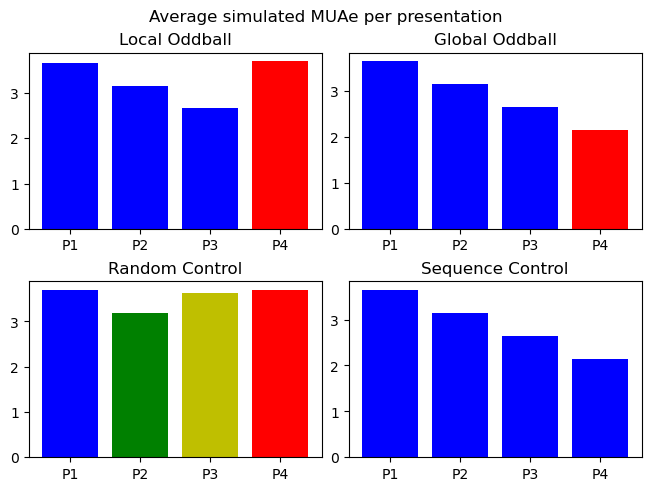

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=2, layout="constrained")
CONDITION_COLORS = {
    "lo": ['b', 'b', 'b', 'r'],
    "go": ['b', 'b', 'b', 'r'],
    "rndctrl": ['b', 'g', 'y', 'r'],
    "seqctrl": ['b', 'b', 'b', 'b'],
}
CONDITION_NAMES = {
    "lo": "Local Oddball",
    "go": "Global Oddball",
    "rndctrl": "Random Control",
    "seqctrl": "Sequence Control"
}

for condition, ax in zip(["lo", "go", "rndctrl", "seqctrl"], list(axes.flatten())):
    xs = np.arange(1, 4+1)
    ax.bar(xs, SYNTHETIC_SAMPLES[condition].mean(dim=0).squeeze().numpy(), color=CONDITION_COLORS[condition], tick_label=["P1", "P2", 'P3', 'P4'])
    ax.set_title(CONDITION_NAMES[condition])

fig.suptitle('Average simulated MUAe per presentation')
fig.savefig("synthetic_adaptation_presentations.pdf", format='pdf', bbox_inches='tight')
fig.show()

In [13]:
generative.baseline_p_loc = nn.Parameter(torch.ones(1) * 2)
generative.baseline_p_log_scale = nn.Parameter(torch.zeros(1))

generative.repetition_p_concentration = nn.Parameter(torch.ones(1))
generative.repetition_p_rate = nn.Parameter(torch.ones(1) * 2)

generative.selectivity_p_concentration = nn.Parameter(torch.ones(1) * 5)
generative.selectivity_p_rate = nn.Parameter(torch.ones(1))

generative.surprise_p_concentration = nn.Parameter(torch.tensor([5., 0.01, 0.01, 0.01]))
generative.surprise_p_rate = nn.Parameter(torch.tensor([5., 5., 5., 5.]))

In [14]:
SYNTHETIC_SAMPLES = {
    "go": [],
    "lo": [],
    "rndctrl": [],
    "seqctrl": []
}

In [15]:
with torch.no_grad():
    while len(SYNTHETIC_SAMPLES["go"]) < 5000:
        with pyro.plate_stack("synthetic", (100, 4)):
            examples = generative.model(None, SYNTHETIC_REGRESSORS)
        if len(SYNTHETIC_SAMPLES["go"]) > 0:
            SYNTHETIC_SAMPLES["lo"] = torch.cat((SYNTHETIC_SAMPLES["lo"], examples[:, 0, :, :]), dim=0)
            SYNTHETIC_SAMPLES["go"] = torch.cat((SYNTHETIC_SAMPLES["go"], examples[:, 1, :, :]), dim=0)
            SYNTHETIC_SAMPLES["rndctrl"] = torch.cat((SYNTHETIC_SAMPLES["rndctrl"], examples[:, 2, :, :]), dim=0)
            SYNTHETIC_SAMPLES["seqctrl"] = torch.cat((SYNTHETIC_SAMPLES["seqctrl"], examples[:, 3, :, :]), dim=0)
        else:
            SYNTHETIC_SAMPLES["lo"] = examples[:, 0, :, :]
            SYNTHETIC_SAMPLES["go"] = examples[:, 1, :, :]
            SYNTHETIC_SAMPLES["rndctrl"] = examples[:, 2, :, :]
            SYNTHETIC_SAMPLES["seqctrl"] = examples[:, 3, :, :]

In [16]:
SYNTHETIC_SAMPLES["lo"].shape

torch.Size([5000, 4, 1])

In [17]:
torch.save((SYNTHETIC_REGRESSORS, SYNTHETIC_SAMPLES), 'data/synthetic_surprise_glo.pt')

/tmp/ipykernel_239242/3732472845.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


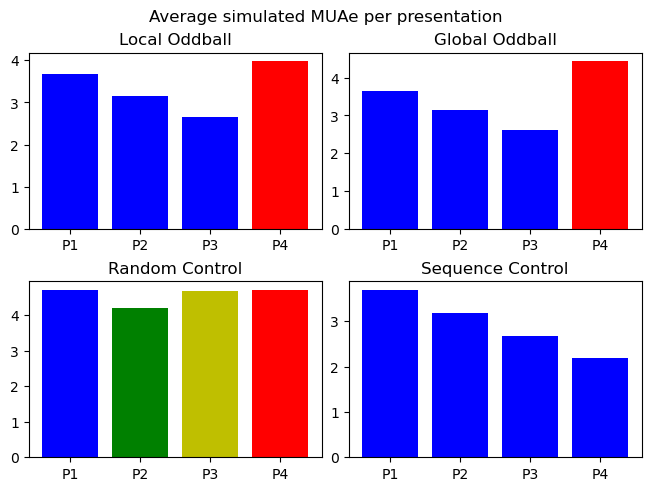

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=2, layout="constrained")
CONDITION_COLORS = {
    "lo": ['b', 'b', 'b', 'r'],
    "go": ['b', 'b', 'b', 'r'],
    "rndctrl": ['b', 'g', 'y', 'r'],
    "seqctrl": ['b', 'b', 'b', 'b'],
}
CONDITION_NAMES = {
    "lo": "Local Oddball",
    "go": "Global Oddball",
    "rndctrl": "Random Control",
    "seqctrl": "Sequence Control"
}

for condition, ax in zip(["lo", "go", "rndctrl", "seqctrl"], list(axes.flatten())):
    xs = np.arange(1, 4+1)
    ax.bar(xs, SYNTHETIC_SAMPLES[condition].mean(dim=0).squeeze().numpy(), color=CONDITION_COLORS[condition], tick_label=["P1", "P2", 'P3', 'P4'])
    ax.set_title(CONDITION_NAMES[condition])

fig.suptitle('Average simulated MUAe per presentation')
fig.savefig("synthetic_surprise_presentations.pdf", format='pdf', bbox_inches='tight')
fig.show()